In [1]:
#https://blog.socratesk.com/blog/2018/01/29/expose-ML-model-as-REST-API
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models

In [2]:
transfer = models.alexnet(pretrained=True)
transfer.classifier[6] = nn.Linear(4096, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:12<00:00, 20298061.29it/s]


In [3]:
def train(n_epochs, loader, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = .091
    train_loss = 0
    valid_loss = 0
    for epoch in range(1, n_epochs+1):
        model.train()
        for batch_idx, (data, target) in enumerate(loader[0]):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            #if batch_idx == 0:
                #print('Started Batch')
            optimizer.zero_grad()       
            output = model(data)        
            loss = criterion(output, target)        
            loss.backward()        
            optimizer.step() 
            torch.cuda.empty_cache() 
            train_loss += loss.item()*data.size(0)
            #if batch_idx % show == 0:
                #print('Training: ' + str(batch_idx))
        model.eval()
        for batch_idx, (data, target) in enumerate(loader[1]):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            torch.cuda.empty_cache()
            #if batch_idx % show == 0:
                #print('Validation: ' + str(batch_idx))
        train_loss = train_loss/len(loader[0].dataset)
        valid_loss = valid_loss/len(loader[1].dataset)
        
        print('Epoch: {} \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
            epoch, train_loss, valid_loss))
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    return model

In [4]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
        
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders[2]):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [17]:
transfer.load_state_dict(torch.load('model.pth'))
transfer.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [71]:
from PIL import Image
def predict(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')    
    in_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    image= image.cuda()
    output = transfer(image)
    index = torch.topk(output,1)
    value = index[1].item()
    if value == 1:
        print("You have Pneumonia, see a doctor!")
    else:
        print("You don't have Pneumonia, phew")

In [72]:
import cv2
def display(img_path):

    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

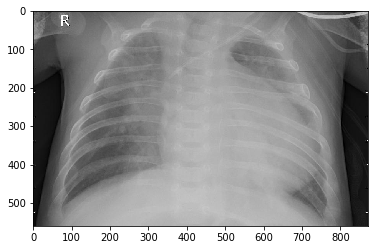

You have Pneumonia, see a doctor!


In [73]:
def run(img):
    display(img)
    predict(img)
run('virus.jpeg')